In [1]:
import sys
sys.path.append('../')
import pickle
from scipy.io import mmread

from config import car_model_directory as model_directory
from utils import remove_alphabet_number_comb
from utils import read_list

index2category = read_list('./car_index.txt')
with open('{}/common_words.pkl'.format(model_directory), 'rb') as f:
    common_words = pickle.load(f)
with open('{}/category_sensitive_words.pkl'.format(model_directory), 'rb') as f:
    category_sensitive_words = pickle.load(f)
with open('{}/subword_df_slot.pkl'.format(model_directory), 'rb') as f:
    params = pickle.load(f)
    index2subword = params['index2subword']
    subword2index = {subword:index for index,subword in enumerate(index2subword)}
    del params
    
print(common_words['차량']) # (nstd, mean, max/mean, argmax_c)

(0.18567, 0.54834, 1.2969, 20)


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
for c, words in enumerate(category_sensitive_words):
    print(c, len(words))

0 3752
1 834
2 572
3 2968
4 3082
5 3267
6 209
7 146
8 319
9 1229
10 1138
11 139
12 120
13 118
14 178
15 78
16 370
17 334
18 237
19 219
20 156
21 586
22 236
23 269
24 1290
25 1472
26 2142


In [ ]:
c = 10
with open('{}/related_words_c{}.pkl'.format(model_directory, c), 'rb') as f:
    W_ij = pickle.load(f)

In [175]:
#     sensitive_words = set(category_sensitive_words[c])
#     common_words = set(common_words)
sensitive_words = set(remove_alphabet_number_comb(category_sensitive_words[c]))
common_words = set(remove_alphabet_number_comb(common_words))
true_specific, false_specific, has_no_relateds = select_specific_words(W_ij, sensitive_words, common_words, cost_factor=1.0, cutoff=0.1)

In [176]:
print('category = {}'.format(index2category[c]))
print('True specific')
print(remove_alphabet_number_comb([word for word, _ in true_specific]))
print('\nFalse specific (common words)')
print(remove_alphabet_number_comb([word for word, _ in false_specific]))
print('\nHas no related words')
print(remove_alphabet_number_comb([word for word, _ in has_no_relateds]))

category = 소나타
True specific
['연주', '피아노', '작곡', '연주하', '베토벤', '작곡가', '바이올', '협주곡', '바이올린', '선율', '연주자', '곡이', '오케스트라', '연주하는', '연주가', '모차르트', '악장', '음악적', '음악가', '음악에', '곡들', '악기', '피아니스트', '연주회', '바흐', '기교', '곡으로', '연주한', '연주되', '브람스', '지휘', '첼로', '슈만', '편곡', '슈베르트', '3악장', '반주', '변주곡', '오페라', '연주할', '연주에', '현악', '지휘자', '교향곡', '작곡한', '1악장', '연주했', '연주해', '곡에', '작곡가들', '2악장', '하이든', '쇼팽', '청중', '서정적', '리듬', '연주한다', '관현악', '멘델스존', '전곡', '악보', '음반', '곡인', '실내악', '연주자들', '선율이', '레퍼토리', '연주되는', '연주회에', '헌정', '작품에', '곡들이', '건반', '음악가들', '연주와', '화음', '바로크', '환상곡', '드뷔시', '성악', '연주하기', '모음곡', '바이올리니스트', '제1번', '초연', '차이코프스키', '청중들', '레퍼', '음악원', '합창', '낭만주의', '4악장', '모짜르트', '클라리넷', '트리오', '곡이라', '음악회', '음악성', '연주하면', '연주회에서', '음악학', '파가니니', '피아니스트로', '장조', '연주했다', '콘체르토', '피아노에', '전주곡', '왈츠', '4중주', '연주자로', '합주', '기악', '작곡가로', '서곡', '춤곡', '작곡하', '음악인', '서정성', '비올라', '피아노곡', '비르투오', '협주곡이', '독주곡', '연습곡', '클라라', '3곡', '바그너', '피날레', '라흐마니노프', '론도', '작곡가이', '아리아', '심포', '푸가', '음악계', '심포니', '현악기'

In [163]:
positive_features = {word for word in common_words}
positive_features.update([word for word, _ in false_specific])
negative_features = {word for word, _ in true_specific}
negative_features.update([word for word, _ in has_no_relateds])

positive_features = {subword2index[word] for word in positive_features}
negative_features = {subword2index[word] for word in negative_features}

x_fname = '{}/subword_tf_c{}.mtx'.format(model_directory, c)
x = mmread(x_fname).tocsr()

In [164]:
def classify_documents(x, positive_features, negative_features, negative_score_factor=1.0):
    n, m = x.shape
    factor = negative_score_factor * len(positive_features) / len(negative_features)
    
    rows, cols = x.nonzero()
    data = x.data
    scores = [0]*n
    unknown_features = [0]*n
    num_features = [0]*n
    normalizer = [0]*n
    
    n_entry = len(rows)
    for i_entry, (i,j,d) in enumerate(zip(rows, cols, data)):
        if i_entry % 5000 == 4999:
            print('\r  - computing ... {} % entries'.format('%.2f'%(100*(i_entry+1)/n_entry)), flush=True, end='')
        num_features[i] = num_features[i] + d
        if j in positive_features:
            scores[i] = scores[i] + d
            normalizer[i] = normalizer[i] + d
        if j in negative_features:
            scores[i] = scores[i] - (factor * d)
            normalizer[i] = normalizer[i] + (factor * d)
        if not (j in positive_features or j in negative_features):
            unknown_features[i] = unknown_features[i] + d
            #scores[i] = scores[i] - d * factor
    scores = [score/normalizer[i] if normalizer[i] > 0 else 0 for i,score in enumerate(scores)]
    unknown_features = [num/num_features[i] for i,num in enumerate(unknown_features) if num_features[i] > 0]
    print('\rclassification was done.{}'.format(' '*50))
    return scores, num_features, unknown_features

In [165]:
scores, num_features, unknown_features = classify_documents(x, positive_features, negative_features, negative_score_factor=1)

classification was done.                                                  


In [166]:
print('len scores =',len(scores))
print('len counter(scores) =',len(Counter(scores)))

len scores = 223363
len counter(scores) = 31592


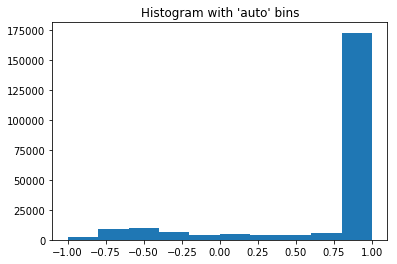

In [167]:
plt.hist(scores, bins=10)
plt.title("Histogram with 'auto' bins")
plt.show()

In [146]:
def make_bow(doc, topk=30):
    import re
    regex = '^[a-zA-Z0-9]+$'
    
    bow = x[doc,:]
    term = bow.nonzero()[1]
    data = bow.data
    bow = sorted([(t,tf) for t,tf in zip(term, data)], key=lambda x:-x[1])
    bow = [(index2subword[t],tf) for t,tf in bow]
    bow = [(t,tf) for t,tf in bow if not re.match(regex, t)][:topk]
    return bow


In [171]:
threshold = 0.8
negative = [i for i, score in enumerate(scores) if score < threshold]
positive = [i for i, score in enumerate(scores) if score > threshold]
print(len(negative), len(positive))

50430 172933


In [169]:
scores[15]

1.0

In [172]:
_counter = 0
# for doc in negative:
for doc in positive:
    bow = make_bow(doc)
    if not bow:
        continue
    print('#doc={}, score={:.4}, unknown_features={:.4}, num_features={}'.format(doc, float(scores[doc]), float(unknown_features[doc]), num_features[doc]))
    print(bow, '\n')
    _counter += 1
    if _counter > 100: break

#doc=2, score=1.0, unknown_features=0.2414, num_features=29
[('휠타이어', 4), ('타이어', 2), ('18인치', 1), ('S1노블', 1), ('YF소나타', 1), ('방문', 1), ('브릴', 1), ('브릴리언트', 1), ('수도', 1), ('수도권', 1), ('싼곳', 1), ('입니다', 1), ('전문', 1), ('조합', 1), ('차량', 1), ('차량입니다', 1), ('타이어8949', 1), ('타이어싼', 1), ('하이', 1), ('하이브리드', 1), ('환영', 1), ('휠타이어전문', 1)] 

#doc=3, score=1.0, unknown_features=0.1701, num_features=147
[('워터', 5), ('워터스', 5), ('유리', 4), ('유리막코팅', 4), ('관리', 3), ('많이', 3), ('완전', 3), ('케미', 3), ('보면', 2), ('블랙', 2), ('블랙컬러', 2), ('상태', 2), ('스크', 2), ('스크레치', 2), ('신차', 2), ('잘하', 2), ('좋은', 2), ('차량', 2), ('차량관리', 2), ('차주', 2), ('차주님', 2), ('차주님께서', 2), ('케미컬', 2), ('힘들', 2), ('힘들어', 2), ('2주', 1), ('ㅜㅜ', 1), ('ㅡㅡ', 1), ('간단', 1), ('같습니다', 1)] 

#doc=4, score=0.9696, unknown_features=0.2283, num_features=714
[('ㅋㅋ', 63), ('ㅋㅋㅋ', 55), ('ㅋㅋㅋㅋ', 32), ('사진', 13), ('엄청', 9), ('우리', 7), ('정말', 7), ('ㅜㅜ', 6), ('ㅜㅜㅜ', 6), ('대륙', 5), ('뮤지', 5), ('아이', 5), ('여기', 5), ('찍어', 5), ('트릭', 5), ('그런', 4), ('